Entropy(Response): 0.61
GinniIndex(Response): 0.25


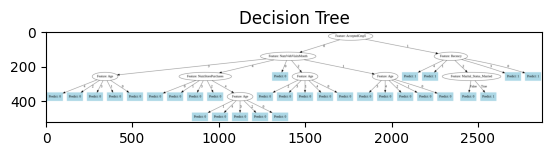

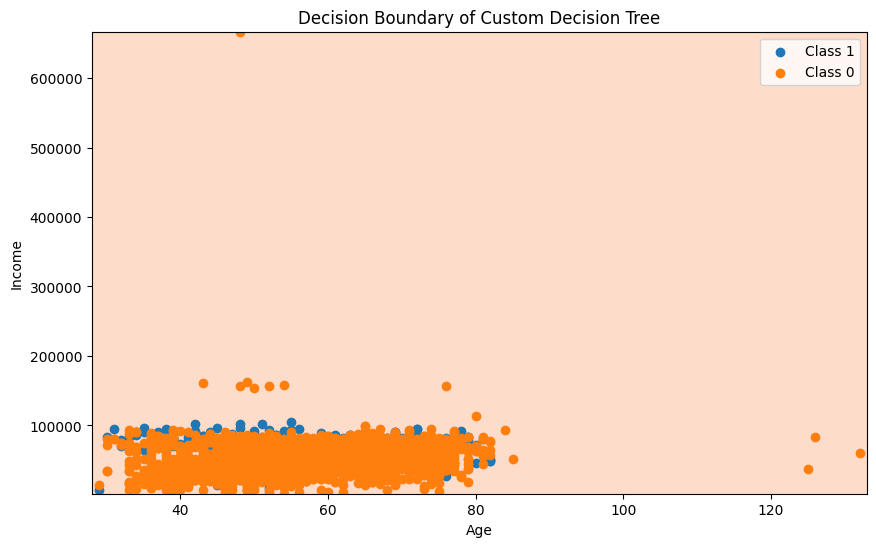

In [3]:
from PIL import Image
import pandas as pd
from datetime import datetime
import numpy as np
import warnings
from graphviz import Digraph
import matplotlib.pyplot as plt

# Ignore all warnings
warnings.filterwarnings("ignore")

#A1
def calcEntropy(target):
  entropy = 0
  probability = target.value_counts(normalize=True)
  for p in probability:
    entropy += -p * np.log2(p)
  return round(entropy, 2)

#A2
def calcGinniIndex(target):
  ginni = 0
  probability = target.value_counts(normalize=True)
  for p in probability:
    ginni += p * (1 - p)
  return round(ginni, 2)

#A4

def equalWidthBinning(feature, n_bins):
  min_val = feature.min()
  max_val = feature.max()
  bin_width = (max_val - min_val) // n_bins
  lower_lim = [min_val + i * bin_width for i in range(n_bins + 1)]

  bins = []
  for val in feature:
    for i, lim in enumerate(lower_lim[::-1]):
      if val >= lim:
        bins.append(i)
        break
  return pd.Series(bins)

def equalFrequencyBinning(feature, n_bins):
  sorted_vals = feature.sort_values().reset_index(drop=True)
  bin_size = feature.shape[0] // n_bins

  # Assign bins in sorted order
  labels = pd.Series(index=sorted_vals.index, dtype="object")
  for i in range(n_bins):
      start = i * bin_size
      end = min((i + 1) * bin_size, feature.shape[0])
      labels[start:end] = i

  # Reorder to match original index
  labels.index = sorted_vals.index
  labels = labels.sort_index()
  return labels

#A3
def conditionalEntropy(feature,target, bin = False, n_bins = 4, binning_type = 'equal width'):
  entropy = 0

  # creating bins if the feature is continuous
  if bin:
    bins = equalWidthBinning(feature, n_bins) if binning_type == 'equal width' else equalFrequencyBinning(feature, n_bins)
    feature = bins

  categories = feature.unique()
  data = pd.DataFrame({'feature': feature, 'target': target})
  category_entropy = {}

  for category in categories:
    category_data = data[data['feature'] == category]
    entropy += (category_data.shape[0] / data.shape[0]) * calcEntropy(category_data['target'])

  return round(entropy, 2)

def informationGain(feature, target, bin = False, n_bins = 4, binning_type = 'equal width'):
  return calcEntropy(target) - conditionalEntropy(feature, target, bin,n_bins, binning_type)

def determineRootNode(df,target, binning_cols = [], n_bins = 4, binning_type = 'equal width'):
  max_info_gain = 0
  root_node = None
  for col in df.columns:
    if col != target:
      info_gain = informationGain(df[col], df[target], col in binning_cols, n_bins, binning_type)
      max_info_gain = max(max_info_gain, info_gain)
      if info_gain == max_info_gain:
        root_node = col
  return root_node

# A5
class DecisionTreeNode:
    def __init__(self, feature=None, children=None, prediction=None):
        self.feature = feature          # feature used for splitting
        self.children = children or {}  # dict of feature value → subtree
        self.prediction = prediction    # prediction if leaf node

def build_tree(df, target, binning_cols=[], n_bins=4, binning_type="equal width", depth=0, max_depth=5):
    # Stopping condition: if all targets same → leaf
    if len(df[target].unique()) == 1:
        return DecisionTreeNode(prediction=df[target].iloc[0])

    # Stopping condition: max depth reached
    if depth == max_depth or df.shape[1] == 1:
        return DecisionTreeNode(prediction=df[target].mode()[0])  # majority class

    # Find best split
    root_feature = determineRootNode(df, target, binning_cols, n_bins, binning_type)

    # If no feature improves → leaf
    if root_feature is None:
        return DecisionTreeNode(prediction=df[target].mode()[0])

    # Create node
    node = DecisionTreeNode(feature=root_feature)

    categories = (equalWidthBinning(df[root_feature], n_bins).unique() if binning_type == 'equal width' else equalFrequencyBinning(df[root_feature], n_bins).unique()) if root_feature in binning_cols else df[root_feature].unique()

    # Create child nodes for each category/bin
    for val in categories:
        subset = df[df[root_feature] == val]
        if subset.empty:
            prediction = df[target].mode()[0]
            node.children[val] = DecisionTreeNode(prediction=prediction)
        else:
            node.children[val] = build_tree(subset.drop(columns=[root_feature]),
                                            target, binning_cols, n_bins,
                                            binning_type, depth + 1, max_depth)
    return node

# A6

def visualize_tree(node, dot=None, parent=None, edge_label=""):
    if dot is None:
        dot = Digraph()

    if node.prediction is not None:
        node_id = str(id(node))
        dot.node(node_id, f"Predict: {node.prediction}", shape="box", style="filled", color="lightblue")
    else:
        node_id = str(id(node))
        dot.node(node_id, f"Feature: {node.feature}", shape="ellipse")

    if parent:
        dot.edge(parent, node_id, label=edge_label)

    if node.children:
        for val, child in node.children.items():
            visualize_tree(child, dot, node_id, str(val))

    return dot

# A7
def predict_tree(node, sample):
    while node.prediction is None:
        feature_val = sample[node.feature]
        if feature_val in node.children:
            node = node.children[feature_val]
        else:
            # fallback to first child if unseen value
            node = list(node.children.values())[0]
    return node.prediction

def plot_decision_boundary(tree, df, features, target):
    x_min, x_max = df[features[0]].min() - 1, df[features[0]].max() + 1
    y_min, y_max = df[features[1]].min() - 1, df[features[1]].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    grid = pd.DataFrame({features[0]: xx.ravel(), features[1]: yy.ravel()})

    # Predict for each point
    Z = grid.apply(lambda row: predict_tree(tree, row), axis=1)
    Z = Z.values.reshape(xx.shape)

    plt.figure(figsize=(10,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # plot original points
    for cls in df[target].unique():
        subset = df[df[target]==cls]
        plt.scatter(subset[features[0]], subset[features[1]], label=f"Class {cls}")

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title("Decision Boundary of Custom Decision Tree")
    plt.legend()
    plt.show()



if __name__ == "__main__":

  df = pd.read_excel("Lab Session Data.xlsx", sheet_name="marketing_campaign")

  # preprocessing
  df['Age'] = datetime.now().year - df['Year_Birth']
  df.drop(columns = ['ID', 'Year_Birth','Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis = 1, inplace= True)
  df = pd.get_dummies(df, columns = ['Education', 'Marital_Status'])
  df.fillna(df.mean(), inplace=True)

  binning_cols = ['Age',
                  'Income',
                  'Recency',
                  'MntWines',
                  'MntFruits',
                  'MntMeatProducts',
                  'MntFishProducts',
                  'MntSweetProducts',
                  'MntGoldProds',
                  'NumDealsPurchases',
                  'NumWebPurchases'	,
                  'NumCatalogPurchases',
                  'NumStorePurchases'	,
                  'NumWebVisitsMonth'
                  ]
  print("Entropy(Response):", calcEntropy(df['Response']))
  print("GinniIndex(Response):", calcGinniIndex(df['Response']))
  tree = build_tree(df, 'Response', binning_cols, n_bins=4, binning_type="equal width")
  dot = visualize_tree(tree)
  dot.render("decision_tree", format="png", cleanup=True)
  img=Image.open("decision_tree.png")

  plt.imshow(img)
  plt.title("Decision Tree")
  plt.show()
  features_2d = ['Age', 'Income']  # or any two numeric features
  tree_2d = build_tree(df[features_2d + ['Response']], 'Response', binning_cols, n_bins=4, binning_type='equal width', max_depth=4)

  # Plot decision boundary
  plot_decision_boundary(tree_2d, df[features_2d + ['Response']], features_2d, 'Response')



